# MLOps workshop with Amazon SageMaker

## Module 01: Transform the data and train a model inside a Jupyter notebook.

In this workshop we will demonstrate a journey to cloud-native machine learning starting from a more traditional approach to model development and training directly in Jupyter notebooks to remote managed data transformations and training with Amazon SageMaker to fully automated pipelines with SageMaker Pipelines.

In this first notebook we will predict house prices based on the well-known California housing dataset with a simple regression model in Tensorflow 2.

To begin, we'll import some necessary packages and set up directories for training and test data. In this notebook, the only usage of SageMaker is to manage the compute of the notebook. There is no usage of SageMaker APIs.

In [48]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn.model_selection
from sklearn.preprocessing import StandardScaler

In [49]:
import os

data_dir = os.path.join(os.getcwd(), 'data')
os.makedirs(data_dir, exist_ok=True)

train_dir = os.path.join(os.getcwd(), 'data/train')
os.makedirs(train_dir, exist_ok=True)

test_dir = os.path.join(os.getcwd(), 'data/test')
os.makedirs(test_dir, exist_ok=True)

raw_dir = os.path.join(os.getcwd(), 'data/raw')
os.makedirs(raw_dir, exist_ok=True)

batch_dir = os.path.join(os.getcwd(), 'data/batch')
os.makedirs(batch_dir, exist_ok=True)

## Exploratory Data Analysis (EDA)

According to The State of Data Science 2020 survey, data management, exploratory data analysis (EDA), feature selection, and feature engineering accounts for more than 66% of a data scientist’s time.

Exploratory Data Analysis is an approach in analyzing data sets to summarize their main characteristics, often using statistical graphics and other data visualization methods. EDA assists Data science professionals in various ways:-

Getting a better understanding of data.
Identifying various data patterns.
Getting a better understanding of the problem statement.
Numerical EDA gives you some very important information, such as the names and data types of the columns, and the dimensions of the DataFrame. Visual EDA on the other hand will give you insight into features and target relationship and distribution.

First we'll load the California Housing dataset and explore the data.

## Download California Housing dataset

We use the California housing dataset.

More info on the dataset:

This dataset was obtained from the StatLib repository. http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).

We will use AWS cli to download the dataset from S3. You don't need to specify AWS credentials. They are assumed from the notebook IAM role. If you get an error in this step, check that the notebook was created with a proper IAM role.

In [50]:
!aws s3 cp s3://sagemaker-sample-files/datasets/tabular/california_housing/cal_housing.tgz .

download: s3://sagemaker-sample-files/datasets/tabular/california_housing/cal_housing.tgz to ./cal_housing.tgz


In [51]:
!tar -zxf cal_housing.tgz 2>/dev/null

In [52]:
columns = [
    "longitude",
    "latitude",
    "housingMedianAge",
    "totalRooms",
    "totalBedrooms",
    "population",
    "households",
    "medianIncome",
    "medianHouseValue",
]
df = pd.read_csv("CaliforniaHousing/cal_housing.data", names=columns, header=None)

In [53]:
df.head()

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


## Numerical EDA
Check how big is dataset, how many and of what type features it has, and what is target.

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   longitude         20640 non-null  float64
 1   latitude          20640 non-null  float64
 2   housingMedianAge  20640 non-null  float64
 3   totalRooms        20640 non-null  float64
 4   totalBedrooms     20640 non-null  float64
 5   population        20640 non-null  float64
 6   households        20640 non-null  float64
 7   medianIncome      20640 non-null  float64
 8   medianHouseValue  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


There are 9 attributes in each case of the dataset. They are:

longitude - block group longitude
latitude - block group latitude
housingMedianAge - median house age in block group
totalRooms - average number of rooms per household
totalBedrooms - average number of bedrooms per household
population - block group population
households - average number of household members
medianIncome - median income in block group
medianHouseValue - median value of owner-occupied homes.
It is important to notice that all data is numeric and there is no NULL values.
Now, let's summarize the data to see the distribution of data

In [55]:
df.describe()

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.898014,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.247906,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,295.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [56]:
df.value_counts("housingMedianAge", sort=True)

housingMedianAge
52.0    1273
36.0     862
35.0     824
16.0     771
17.0     698
34.0     689
26.0     619
33.0     615
18.0     570
25.0     566
32.0     565
37.0     537
15.0     512
19.0     502
27.0     488
24.0     478
30.0     476
28.0     471
20.0     465
29.0     461
31.0     458
23.0     448
21.0     446
14.0     412
22.0     399
38.0     394
39.0     369
42.0     368
44.0     356
43.0     353
40.0     304
13.0     302
41.0     296
45.0     294
10.0     264
11.0     254
46.0     245
5.0      244
12.0     238
8.0      206
9.0      205
47.0     198
4.0      191
48.0     177
7.0      175
6.0      160
50.0     136
49.0     134
3.0       62
2.0       58
51.0      48
1.0        4
dtype: int64

We can see that houses are rather old, around 28 years, looking at the mean.

## Visual EDA

Let's begin exploring the data by using visualization.We will plot the histogram of each feature.

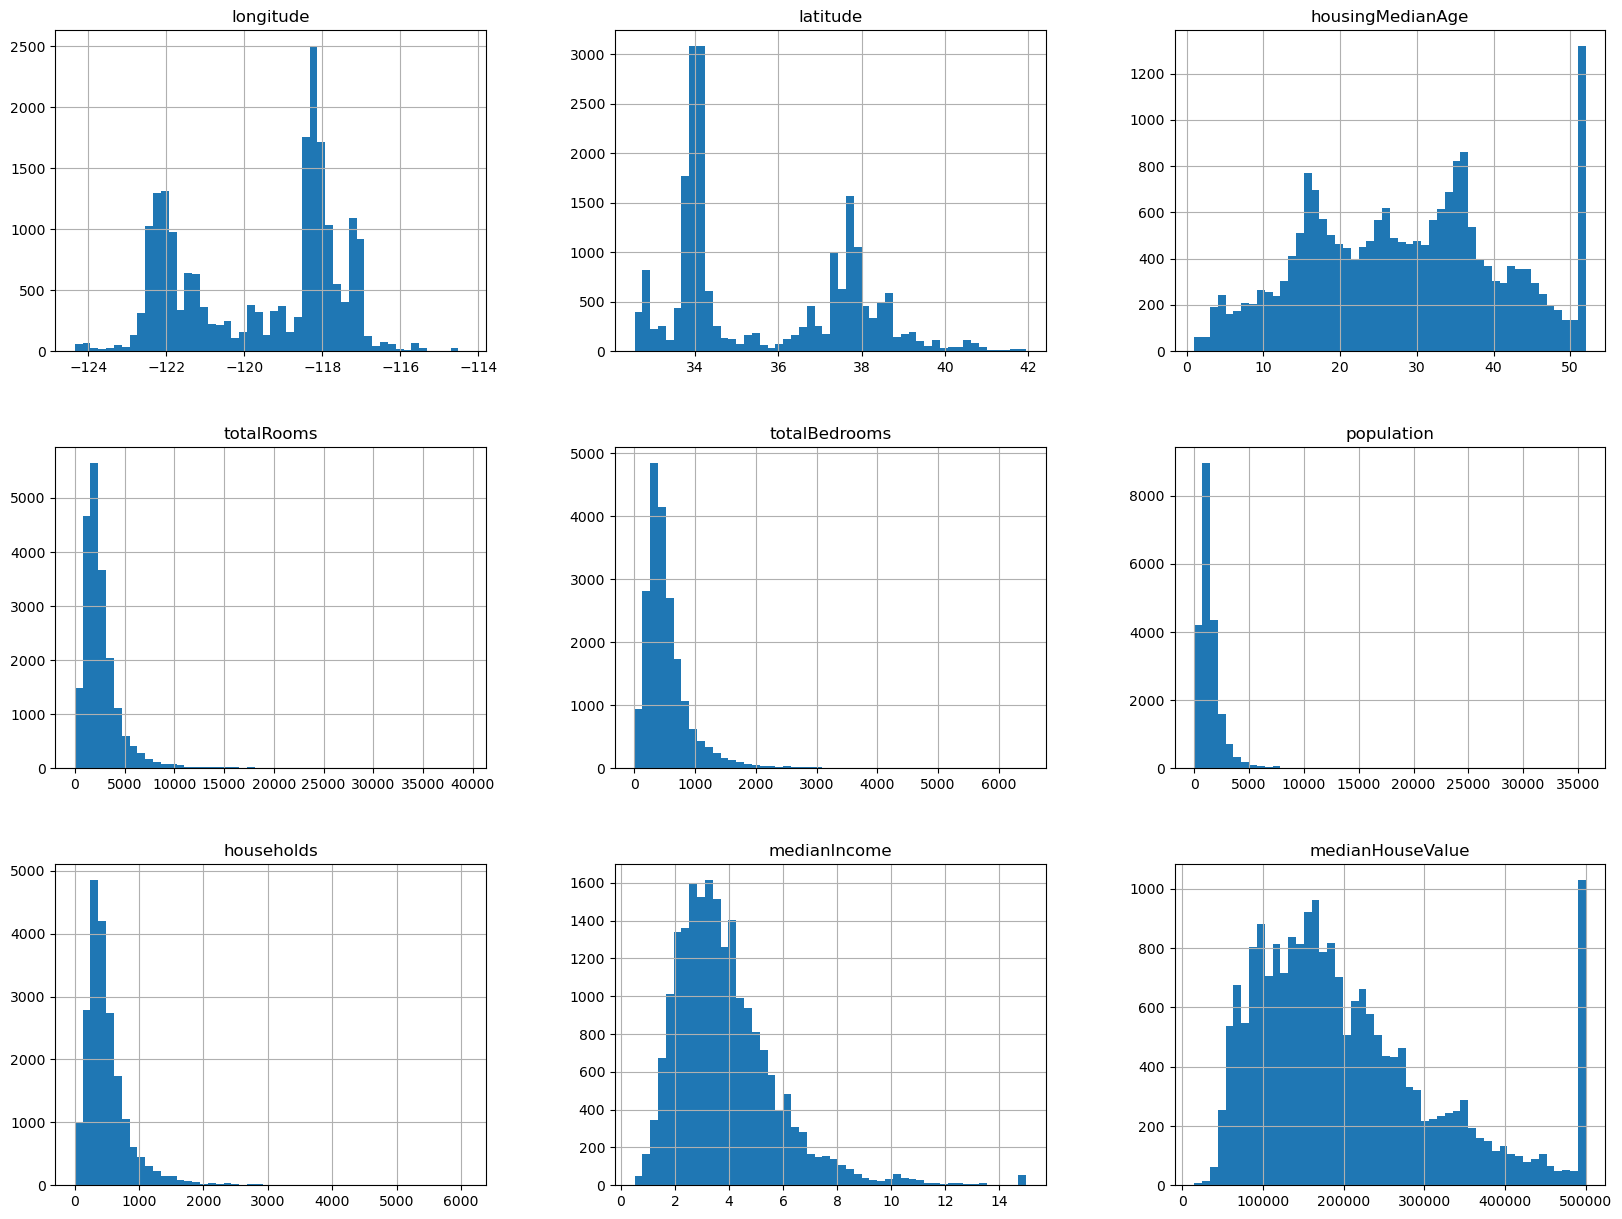

In [57]:
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20, 15))
plt.show()

We see that the data is skewed and not normalized for most of the columns. We will not touch the latitude and longitude for now. Let's apply the logarithmic function to the rest of the columns and check the result.

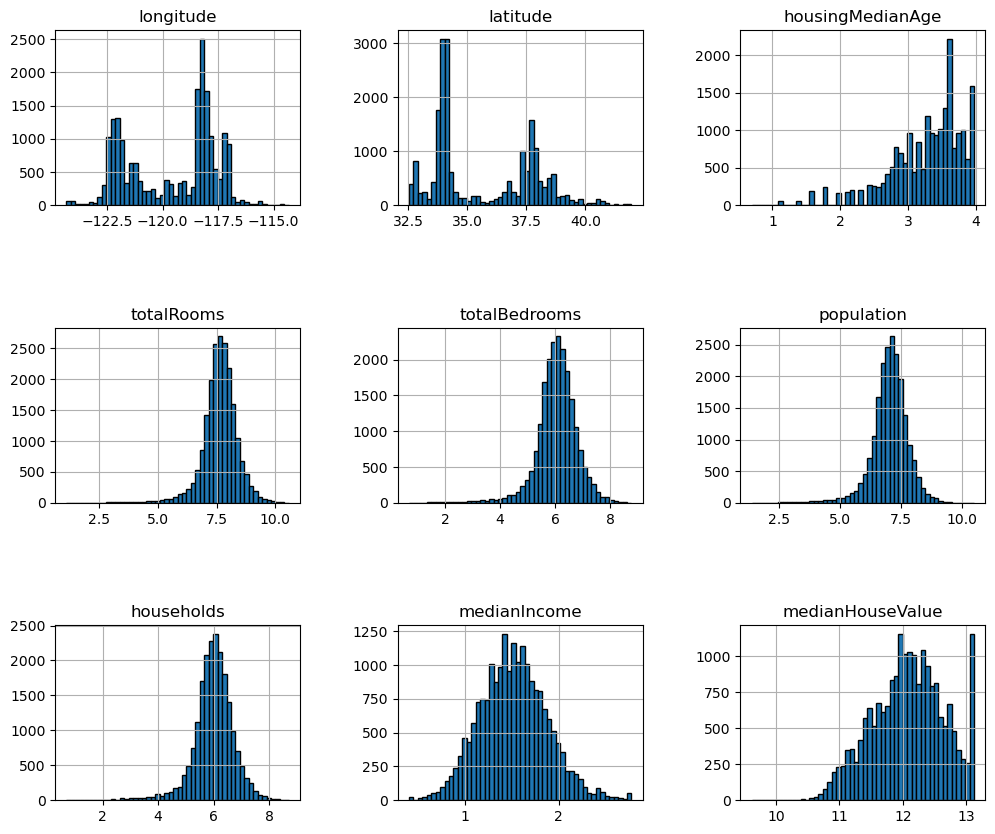

In [58]:
df['medianIncome']=np.log1p(df['medianIncome'])
df['housingMedianAge']=np.log1p(df['housingMedianAge'])
df['totalRooms']=np.log1p(df['totalRooms'])
df['totalBedrooms']=np.log1p(df['totalBedrooms'])
df['population']=np.log1p(df['population'])
df['households']=np.log1p(df['households'])
df['medianHouseValue']=np.log1p(df['medianHouseValue'])
df.hist(figsize=(12, 10), bins=50, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

The data looks much better.  Now we will check the coordinates. First of all, we will plot the coordinates and use the "medianHouseValue" column for coloring.

<Figure size 1000x1000 with 0 Axes>

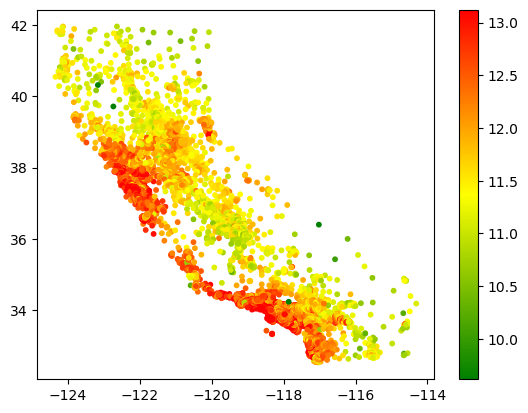

In [59]:
from matplotlib.colors import LinearSegmentedColormap

plt.figure(figsize=(10,10))

cmap = LinearSegmentedColormap.from_list(name='Pacific Ocean shore', colors=['green','yellow','red'])

f, ax = plt.subplots()
points = ax.scatter(df['longitude'], df['latitude'], c=df['medianHouseValue'], s=10, cmap=cmap)
f.colorbar(points)

Our dataset is about California. What we see in the plot is the Pacific Ocean shore. From the diagram (using the color indicator), it is clear that houses located near the ocean are more expensive. Using the human knowledge domain, we also notice that the most expensive houses are located near San Francisco (37.7749° N, 122.4194° W) and Los Angeles (34.0522° N, 118.2437°). Another observation is the relationship between house prices and the distance to those locations. We will engineer the data to produce linear dependencies between the house price and the location, which is a good fit for linear regression problems.We remove the "longitude" and the "latitude" columns and replace them with Euclidian distances to San Francisco and  Los Angeles.

In [60]:
sf_coord=[-122.4194, 37.7749]
la_coord=[-118.2437, 34.0522]

df['DistanceToSF']=np.sqrt((df['longitude']-sf_coord[0])**2+(df['latitude']-sf_coord[1])**2)
df['DistanceToLA']=np.sqrt((df['longitude']-la_coord[0])**2+(df['latitude']-la_coord[1])**2)
df.drop(columns=['longitude', 'latitude'],inplace=True)

Split the data to create training and validation datasets

In [61]:
X = df[['DistanceToSF','DistanceToLA','housingMedianAge','totalRooms','totalBedrooms','population','households','medianIncome']]
Y = df[['medianHouseValue']]

In [62]:
print("Features:", list(X.columns))
print("Dataset shape:", X.shape)
print("Dataset Type:", type(X))
print("Label set shape:", Y.shape)
print("Label set Type:", type(X))

# We partition the dataset into 2/3 training and 1/3 test set.
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.33)

np.save(os.path.join(raw_dir, 'x_train.npy'), x_train)
np.save(os.path.join(raw_dir, 'x_test.npy'), x_test)
np.save(os.path.join(raw_dir, 'y_train.npy'), y_train)
np.save(os.path.join(raw_dir, 'y_test.npy'), y_test)

Features: ['DistanceToSF', 'DistanceToLA', 'housingMedianAge', 'totalRooms', 'totalBedrooms', 'population', 'households', 'medianIncome']
Dataset shape: (20640, 8)
Dataset Type: <class 'pandas.core.frame.DataFrame'>
Label set shape: (20640, 1)
Label set Type: <class 'pandas.core.frame.DataFrame'>


In [63]:
scaler = StandardScaler()
x_train = np.load(os.path.join(raw_dir, 'x_train.npy'))
scaler.fit(x_train)

StandardScaler()

We save the training and test data on the file system.

In [64]:
input_files = glob.glob('{}/raw/*.npy'.format(data_dir))
print('\nINPUT FILE LIST: \n{}\n'.format(input_files))
for file in input_files:
    raw = np.load(file)
    # only transform feature columns
    if 'y_' not in file:
        transformed = scaler.transform(raw)
    if 'train' in file:
        if 'y_' in file:
            output_path = os.path.join(train_dir, 'y_train.npy')
            np.save(output_path, raw)
            print('SAVED LABEL TRAINING DATA FILE\n')
        else:
            output_path = os.path.join(train_dir, 'x_train.npy')
            np.save(output_path, transformed)
            print('SAVED TRANSFORMED TRAINING DATA FILE\n')
    else:
        if 'y_' in file:
            output_path = os.path.join(test_dir, 'y_test.npy')
            np.save(output_path, raw)
            print('SAVED LABEL TEST DATA FILE\n')
        else:
            output_path = os.path.join(test_dir, 'x_test.npy')
            np.save(output_path, transformed)
            print('SAVED TRANSFORMED TEST DATA FILE\n')


INPUT FILE LIST: 
['/home/ec2-user/SageMaker/data/raw/x_test.npy', '/home/ec2-user/SageMaker/data/raw/x_train.npy', '/home/ec2-user/SageMaker/data/raw/y_train.npy', '/home/ec2-user/SageMaker/data/raw/y_test.npy']

SAVED TRANSFORMED TEST DATA FILE

SAVED TRANSFORMED TRAINING DATA FILE

SAVED LABEL TRAINING DATA FILE

SAVED LABEL TEST DATA FILE



In [65]:
import numpy as np
import os
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

def get_train_data(train_dir):
    x_train = np.load(os.path.join(train_dir, 'x_train.npy'))
    y_train = np.load(os.path.join(train_dir, 'y_train.npy'))
    print('x train', x_train.shape,'y train', y_train.shape)

    return x_train, y_train


def get_test_data(test_dir):
    x_test = np.load(os.path.join(test_dir, 'x_test.npy'))
    y_test = np.load(os.path.join(test_dir, 'y_test.npy'))
    print('x test', x_test.shape,'y test', y_test.shape)

    return x_test, y_test

def get_model():
    inputs = tf.keras.Input(shape=(8,))
    hidden_1 = tf.keras.layers.Dense(8, activation='tanh')(inputs)
    hidden_2 = tf.keras.layers.Dense(4, activation='relu')(hidden_1)
    outputs = tf.keras.layers.Dense(1)(hidden_2)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

Now we will do the actual training. Feel free to change the hyperparameter values (epochs,batch_size, etc.) to see how they affect the training metric.

In [66]:
x_train, y_train = get_train_data(train_dir)
x_test, y_test = get_test_data(test_dir)

device = '/cpu:0'
print(device)
batch_size = 128
epochs = 25
learning_rate = 0.01
print('batch_size = {}, epochs = {}, learning rate = {}'.format(batch_size, epochs, learning_rate))

with tf.device(device):
    model = get_model()
    optimizer = tf.keras.optimizers.SGD(learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
              validation_data=(x_test, y_test))

    # evaluate on test set
    scores = model.evaluate(x_test, y_test, batch_size, verbose=2)
    print("\nTest MSE :", scores)

x train (13828, 8) y train (13828, 1)
x test (6812, 8) y test (6812, 1)
/cpu:0
batch_size = 128, epochs = 25, learning rate = 0.01
Epoch 1/25
109/109 [==============================] - 1s 3ms/step - loss: 11.6964 - val_loss: 0.2383
Epoch 2/25
109/109 [==============================] - 0s 2ms/step - loss: 0.1662 - val_loss: 0.1535
Epoch 3/25
109/109 [==============================] - 0s 2ms/step - loss: 0.1472 - val_loss: 0.2002
Epoch 4/25
109/109 [==============================] - 0s 2ms/step - loss: 0.1401 - val_loss: 0.1580
Epoch 5/25
109/109 [==============================] - 0s 2ms/step - loss: 0.1347 - val_loss: 0.1383
Epoch 6/25
109/109 [==============================] - 0s 2ms/step - loss: 0.1323 - val_loss: 0.1258
Epoch 7/25
109/109 [==============================] - 0s 2ms/step - loss: 0.1300 - val_loss: 0.1527
Epoch 8/25
109/109 [==============================] - 0s 2ms/step - loss: 0.1286 - val_loss: 0.1320
Epoch 9/25
109/109 [==============================] - 0s 2ms/step - 

Mean Squared Error (MSE) is a commonly used metric in machine learning for evaluating the performance of regression models. It measures the average squared difference between the predicted and actual values. MSE penalizes larger errors more heavily due to the squaring operation. By calculating the mean of these squared differences, MSE provides a single numerical value to assess the model's accuracy. A lower MSE indicates better model performance, with zero being the ideal value.

In [67]:
model.save('model' + '/1')

In [68]:
!ls -R model

model:
1

model/1:
assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables

model/1/assets:

model/1/variables:
variables.data-00000-of-00001  variables.index


Our model is trained now, and the metric is good. We will check the "test" dataset to see how close our prediction is to actual values

In [69]:
import numpy as np
import tensorflow as tf

model = tf.keras.models.load_model('model/1')

x_test = np.load(os.path.join(test_dir, 'x_test.npy'))
y_test = np.load(os.path.join(test_dir, 'y_test.npy'))
scores = model.evaluate(x_test, y_test, verbose=2)
print("\nTest MSE :", scores)

213/213 - 0s - loss: 0.1168 - 271ms/epoch - 1ms/step

Test MSE : 0.11675016582012177


213/213 [==============================] - 0s 994us/step


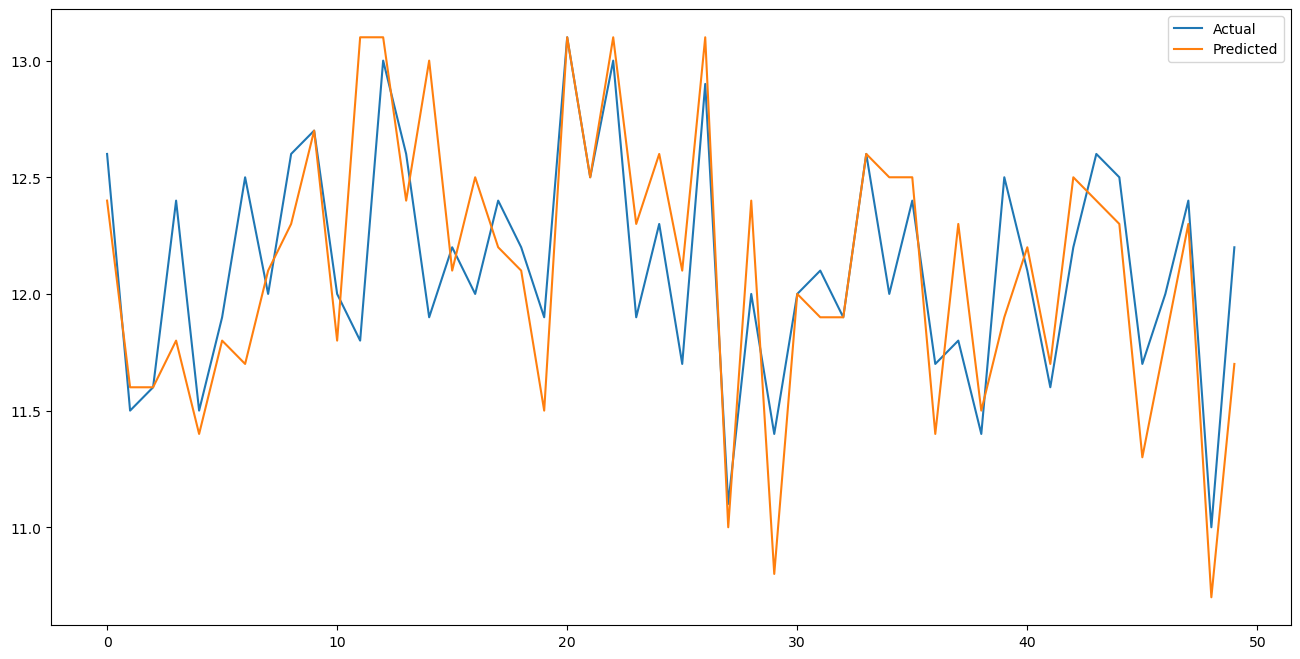

In [70]:
 y_pred = model.predict(x_test)
flat_list_pred = [float('%.1f'%(item)) for sublist in y_pred for item in sublist]
flat_list_test = [float('%.1f'%(item)) for sublist in y_test for item in sublist]
test_result = pd.DataFrame({'Predicted':flat_list_pred,'Actual':flat_list_test})
test_result
fig= plt.figure(figsize=(16,8))
test_result = test_result.reset_index()
test_result = test_result.drop(['index'],axis=1)
plt.plot(test_result[:50])
plt.legend(['Actual','Predicted'])

The MSE metric suggested that our model would perform well, and indeed, we see in the visualization above a good correlation between actual and predicted values.